**Warning** ProductMeasure from `For(N) ... do i ...` broken since MeasureTheory.jl v0.11.3 which bumped MeasureBase.jl to v0.3

In [1]:
# Start current environment
using Pkg
Pkg.activate(".")
Pkg.instantiate()
# Load and precompile the used packages
using CSV, DataFrames, StatsPlots, Statistics
using MeasureTheory, Soss
gr(size=(800,400))

  Activating environment at `c:\Users\Ub\Documents\Code\BayesianMethodsForHackers\BayesianMethodsSoss\Project.toml`
     Cloning git-repo `https://github.com/Tuebel/MeasureTheory.jl.git`
   Installed LabelledArrays ──────────── v1.6.5
   Installed PositiveFactorizations ──── v0.2.4
   Installed SimplePolynomials ───────── v0.2.7
   Installed LinearAlgebraX ──────────── v0.1.9
   Installed NLSolversBase ───────────── v7.8.1
   Installed ExprTools ───────────────── v0.1.6
   Installed LineSearches ────────────── v7.1.1
   Installed InfiniteArrays ──────────── v0.11.2
   Installed RingLists ───────────────── v0.2.6
   Installed ArrayLayouts ────────────── v0.7.7
   Installed KeywordCalls ────────────── v0.2.3
   Installed NameResolution ──────────── v0.1.5
   Installed Intervals ───────────────── v1.5.0
   Installed Soss ────────────────────── v0.20.6
   Installed GeneralizedGenerated ────── v0.3.2
   Installed Multisets ───────────────── v0.4.3
   Installed CodecZlib ───────────────── v0

Plots.GRBackend()

# Load and visualize the data
CSV supports Tables.jl and can be loaded into a `DataFrame`

**Warning** Soss does not like implicit conversions -> Convert data to vector of Integers

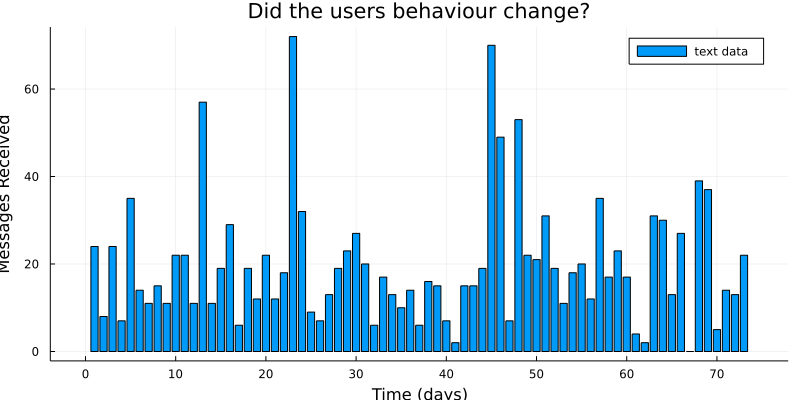

In [2]:
txt_df = CSV.File("../data/chapter1/txtdata.csv") |> DataFrame
txt_data = [Int(x) for x in txt_df[:,1]]
bar(txt_data, title="Did the users behaviour change?", xlabel="Time (days)", xticks=0:10:80, ylabel="Messages Received", label="text data")

# Model
- The number of text messages per day is discrete and thus assumed to be Poisson distributed
- It is assumed that the number of received text messages changes once at day $\tau$
- Thus, two different parameters $\lambda_i$ are required for two differen Poisson distributions
- Exponential distribution has expected value as parameter $e^{\theta}$

In [ ]:
λ_model = @model θ begin
  λ ~ Exponential(θ)
end
λ_model_ret = @model θ begin
  λ ~ Exponential(θ)
  return λ
end


How to use the previously defined model for $\lambda$ as a nested model:
* Parameters passed to the nested model must be named `λ_model(θ=θ)`
* Samples from the nested model contain values of all variables as named tuple. These need to be referenced by their  e.g. `λ_1.λ`

Control flow handling is not documented that well but it seems to work when wrapping it in a statement, i.e. `y~if condition ... else...`

Loops require `For(N) do i` to construct a ProductMeasure instead of `for ... in ...`

In [3]:
model = @model x begin
  N = length(x)
  # MeasureTheory.jl: exp(θ), for E[Exponential(θ)] = 1/θ != mean(data) choose:
  θ = 1/mean(x)
  λ_1 ~ Exponential(θ)
  λ_2 ~ Exponential(θ)
  # Discrete Uniform not implemented yet -> special case of Categorical
  τ ~ Categorical(fill(1/N, N))
  y ~ For(1:N) do i
      if i < τ
          Poisson(λ_1)
      else
          Poisson(λ_2)
      end
  end
end

@model x begin
        θ = 1 / mean(x)
        λ_2 ~ Exponential(θ)
        λ_1 ~ Exponential(θ)
        N = length(x)
        τ ~ Categorical(fill(1 / N, N))
        y ~ For(1:N) do i
                if i < τ
                    Poisson(λ_1)
                else
                    Poisson(λ_2)
                end
            end
    end


## Assign values to arguments
If we want to sample from the model, we need to assign values to the arguments.

In [4]:
concrete_model = model(x=txt_data)
rand(concrete_model)

(θ = 0.050414364640883974, N = 73, λ_2 = 32.57895069319785, λ_1 = 50.80932652165596, τ = 67, y = [61, 61, 58, 60, 52, 49, 55, 44, 46, 52  …  52, 50, 49, 26, 29, 34, 26, 34, 35, 33])

## Conditional Models
We can also condition the model on the data, which will be usefull when using the model for **inference**.
`Soss.logdensity` does not convert the datatype implicitly,. Maybe it is a problem with MeasureTheory.jl. Output of Poisson are Integers.

In [5]:
txt_data_int = [Int(x) for x in txt_data]
conditional_model = concrete_model | (;y=txt_data_int)

ConditionalModel given
    arguments    (:x,)
    observations (:y,)
@model x begin
        θ = 1 / mean(x)
        λ_2 ~ Exponential(θ)
        λ_1 ~ Exponential(θ)
        N = length(x)
        τ ~ Categorical(fill(1 / N, N))
        y ~ For(1:N) do i
                if i < τ
                    Poisson(λ_1)
                else
                    Poisson(λ_2)
                end
            end
    end



# Proposal Model
This model contains the variables that should be modified by the inference algorithm.

The variables in this model should typically not depend on other random variables of the model, since they can be obtained by ancestral sampling. 

# Metropolis Hastings implementation
Store the required variables in a struct:
- `m`: the full model
- `proposals`: variables to propose, other variables are sampled via ancestral sampling
- `data`: fit the model parameters to these observations
- `q`: model for the variables in `proposals`, e.g. before(m, (:a, :b))(args)
- `f`: model for the internal variables, must not include observations, moves params to args, e.g. predictive(m, (:a, :b))(args)
- `ℓ`: logdensity for the model parameters θ conditioned on the data, e.g. ℓ(θ)=logdensity(m(args) | data, θ)

In [6]:
# Immutable for a given set of args and parameters -> new data new MetropolisHastings
struct MetropolisHastings
  m::Soss.AbstractModel
  propsals::Tuple
  data::NamedTuple 
  q::Soss.ConditionalModel
  f::Soss.ConditionalModel
  ℓ::Function
end

Construct the MH for the model `m`

In [7]:
function MetropolisHastings(m::Soss.Model, args::NamedTuple, proposals::Tuple, data::NamedTuple)
  # only proposal variables
  q = Soss.before(model, proposals...)(args)
  # other variables except observations, moves params to args
  f = prior(predictive(model, proposals...), keys(data)...)(args)
  # function to calculate the loglikelihood
  ℓ(θ) = logdensity(m(args) | data, θ)
  MetropolisHastings(m, proposals, data, q, f, ℓ)
end

args = (;x = txt_data)
proposals = (:θ, :λ_1, :λ_2)
data = (;y = txt_data)
mh = MetropolisHastings(model, args, proposals, data);

# Proposals
## Prior Proposal
Draws a random sample from the prior distribution. Results in a worse acceptance rate, if the posterior is focused on a small parameter space.

In [8]:
function propose_prior(mh::MetropolisHastings)
  ## propose, predict, concatenate, weight
  s1 = rand(mh.q)
  s2 = rand(mh.f(s1))
  s = (;s1..., s2...)
  Weighted(mh.ℓ(s), s)
end
s1 = propose_prior(mh)

Weighted(-765.4, (θ = 0.050414364640883974, λ_2 = 8.49860995631882, λ_1 = 14.996935483561444, N = 73, τ = 26)


# Gaussian Proposal
Propose a new sample from the old sample `s` by sampling using a normal distribution centered around the value of the old parameter.
Might lead to a higher acceptance rate for focused posteriors.
Current implementation is brittle: If the parameters are bounded, e.g. $\lambda$ of a Poisson distribution. Mature libraries like Turing.jl typically take care of this by transforming variables to the space of all real numbers and back to the constrained space.

In [9]:
# TODO different standard deviations for different parameters (Gibbs?)
function propose_normal(mh::MetropolisHastings, s::Weighted, σ=1.0)
  old_sample = s.val
  s1 = (;)
  for (k, v) in pairs(old_sample)
    # Other variables are sampled via f
    if k in mh.propsals
      # TODO parameter values might become invalid (i.e. negative for poisson)
      new_val = rand(Normal(v, σ))
      # if the parameter is an integer, the new one should also be
      if v isa Int
        new_val = Int(round(new_v))
      end
      s1 = merge(s1, (;k => new_val))
    end
  end
  s2 = rand(mh.f(s1))
  s = (;s1..., s2...)
  Weighted(mh.ℓ(s), s)
end
s2 = propose_normal(mh, s1, 2)

Weighted(-757.3, (θ = 0.0626903699268889, λ_2 = 10.024577934446054, λ_1 = 14.065016922551617, N = 73, τ = 9)


# Kernels
Returns either the `old_sample` or the `new_sample` depending on their probability and the `acceptance` rate $\in [0,1]$ . Simplified by using a normal distribution for the proposal, which is symmetric.

In [10]:
function mh_symmetric_kernel(old_sample::Weighted, new_sample::Weighted)
  u = rand(Uniform())
  # Mind the log-domain: division becomes subtraction
  if log(u) > new_sample.ℓ - old_sample.ℓ
    # reject
    return old_sample
  else
    # accept (always the case if difference positive since log([0,1])->[-inf,0])
    return new_sample
  end
end
mh_symmetric_kernel(s1, s2)

Weighted(-757.3, (θ = 0.0626903699268889, λ_2 = 10.024577934446054, λ_1 = 14.065016922551617, N = 73, τ = 9)


# Evaluation

Iteratively use the Metropolis Hastings algorithm to propose and evaluate samples to form a chain.

In [11]:
n_samples = 30_000
chain = [propose_prior(mh)]
for _ in 2:n_samples
  new_sample = last(chain)
  try
    # might fail with ArgumentError for Poisson, if λ < 0
    ## new_sample = propose_normal(mh, new_sample, 5)
  catch e
    if !(e isa ArgumentError)
      println(e)
    end
  end
  # worse mixing than normal
  new_sample = propose_prior(mh)
  new_sample = mh_symmetric_kernel(last(chain), new_sample)
  push!(chain, new_sample)
end;

In [12]:
df_c = DataFrame(chain)
df = DataFrame(df_c.val)
df[!,:ℓ] = df_c.ℓ
;

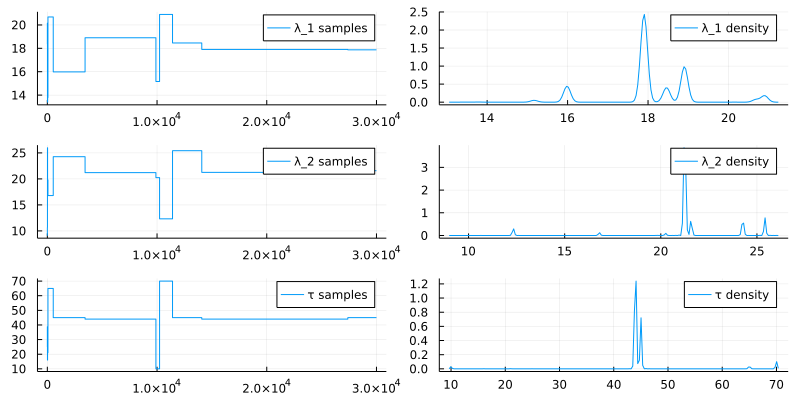

In [13]:
l1 = plot(df.λ_1, label="λ_1 samples")
d1 = StatsPlots.density(df.λ_1, label="λ_1 density")
l2 = plot(df.λ_2, label="λ_2 samples")
d2 = StatsPlots.density(df.λ_2, label="λ_2 density")
l3 = plot(df.τ, label="τ samples")
d3 = StatsPlots.density(df.τ, label="τ density")
plot(l1, d1, l2, d2, l3, d3, layout=(3,2))

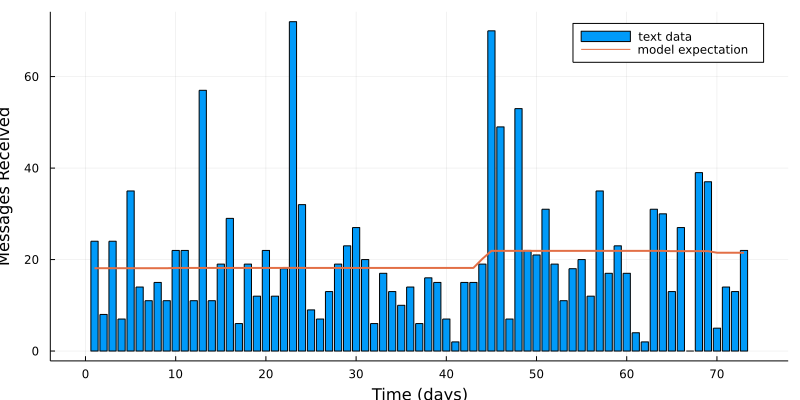

In [14]:
using LinearAlgebra
expected_texts = zeros(length(txt_data))
for day = eachindex(txt_data)
    ix = [day < τ for τ in df.τ]
    expected_texts[day] = sum(ix ⋅ df.λ_1) + sum(.!ix ⋅ df.λ_2)
    expected_texts[day] = expected_texts[day] / length(ix)
end
bar(txt_data, xlabel="Time (days)", xticks=0:10:80, ylabel="Messages Received", label="text data")
plot!(expected_texts, label="model expectation", linewidth=2)

# Thoughts
- Nice idea of code generation an manipulation, for example generating a prior or likelihood model from the model
- Code Generation might become really usefull if I wan to put the likelihood model on the GPU
- Not very mature, a lot of breaking changes recently
- Almost no documentation or examples
- Nested Models, Distributions have some issues for code generation

Gen
- Gen is obviously the more low level PPL compared to Turing
- More boilerplate code is required
- Wording seems to be too unique
- Flexibility is a big plus:
    - sampling from other generative function
    - providing complex models like [inverse graphics](https://news.mit.edu/2015/better-probabilistic-programming-0413) or [complex priors from NNs](https://github.com/probcomp/Gen.jl/tree/master/examples/inverse_graphics)
- The idea of just providing a model which generates the data for inference is clear
- Hackable at all stages

## Soss specifics
Soss uses the `@model` to define a model using the distriutions from MeasureTheoy.jl.Models can be composed or nested.
- The arguments after`@model` seem to be assumed to be known and are **purged** in the model when specified defined as variable.
  Thus, we need to introduce a new variabl `y` for the data instead of `x`.
  These arguments are listed int when calling `arguments(model)`.
- However, setting values for no-argument variables of the model via `model(x=42)` seems to work, too.
The Soss [FAQ](https://github.com/cscherrer/Soss.jl/wiki/FAQ) gives the following explanation:
> Models are like functions. In this case, m1 is a closure, so the n in the body comes from the scope in which the model was defined, just as For and Normal are defined.
> In m2, n is an argument, just like the argument of a function, so it's easy to evaluate it on different values of n.

- I have seen that `arguments` and `observations` are used by some inference algorithms.
- Using both, MeasureTheory.jl & Distributions.jl is [possible](https://discourse.julialang.org/t/using-measuretheory-jl-with-distributions-jl/60737) since the later is a dependency of ther former. Use `Dist.*`
- There seems to be an ongoing switch from Distributions.jl to MeasureTheroy.jl - some methods do not work for Distributions.jl anymore, e.g. `generate` and `xform`. MeasureTheroy.jl is missing discrete / categorical distributions.

- Either return value from nested function or call `retval.variable`
- Some functions like `sampled` have problems with nested models

- evaluating the  `logdensity` is a bit tricky. The first argument is a ConditionalModel, the second the values of the parameters.
  The ConditionalModel can contain the observations, in which case the observation must not be part of the parameters.
  In case the observations are not part of the Conditional model, they must be provided with the parameters.
- nested models cause trouble when evalueating the `logdensity`

# Transformations


In [15]:
prior_model = prior(model, :y)

@model x begin
        θ = 1 / mean(x)
        λ_2 ~ Exponential(θ)
        λ_1 ~ Exponential(θ)
        N = length(x)
        τ ~ Categorical(fill(1 / N, N))
    end


In [16]:
predictive_model = predictive(model, :y)

@model begin
    end


In [17]:
predictive_model = predictive(model, :x)

@model x begin
        θ = 1 / mean(x)
        λ_2 ~ Exponential(θ)
        λ_1 ~ Exponential(θ)
        N = length(x)
        τ ~ Categorical(fill(1 / N, N))
        y ~ For(1:N) do i
                if i < τ
                    Poisson(λ_1)
                else
                    Poisson(λ_2)
                end
            end
    end


In [18]:
likelihood_model = likelihood(model, :y)

@model (N, λ_1, τ, λ_2) begin
        y ~ For(1:N) do i
                if i < τ
                    Poisson(λ_1)
                else
                    Poisson(λ_2)
                end
            end
    end


# Inference Primitives
- "At its core, Soss is about source code generation." ([doc](https://cscherrer.github.io/Soss.jl/stable/misc/)).
- What is required for each primitive, i.e. which parameters need to be known

Some explanations, not found in the docs but in an [issue](https://github.com/cscherrer/Soss.jl/pull/262)
- xform to find a transform from R^n,
- testvalue which is like rand but instead just calls testvalue at each point,
- basemeasure that aggregates calls to basemeasure to end up with a base measure for the model as a whole
- entropy that computes the entropy of a model through a combination of particles and calls to Distributions.entropy

Logdensity via source code generation

Model need to be a concrete model and can only contain distributions from MeasureTheory.jl.

In [19]:
λ_model | (;λ=1)

LoadError: UndefVarError: λ_model not defined

In [ ]:
fn = codegen(λ_model(θ=1))

LoadError: UndefVarError: λ_model not defined

Model needs to be concrete, i.e. all arguments need to be known.

In [ ]:
rand_src = sourceRand(model)

:(_rng->begin
          θ = 1 / mean(x)
          λ_2 = rand(_rng, Exponential(θ))
          λ_1 = rand(_rng, Exponential(θ))
          N = length(x)
          τ = rand(_rng, Categorical(fill(1 / N, N)))
          y = rand(_rng, For(1:N) do i
                      #= In[3]:10 =#
                      if i < τ
                          #= In[3]:11 =#
                          Poisson(λ_1)
                      else
                          #= In[3]:13 =#
                          Poisson(λ_2)
                      end
                  end)
          (N = N, θ = θ, λ_1 = λ_1, λ_2 = λ_2, τ = τ, y = y)
      end)

Work only for non-nested and without Distributions

In [ ]:
simulate(λ_model(θ=1))

LoadError: UndefVarError: λ_model not defined

In [ ]:
codegen(λ_model(θ=1))

LoadError: UndefVarError: λ_model not defined

In [ ]:
function select_sampled_vars(m::Soss.AbstractModel, s::NamedTuple)
  sampled_vars = sampled(m)
  selected =(;)
  for (k, v) in pairs(s)
    if k in sampled_vars
      selected = merge(selected, (;k => v))
    end
  end
  selected
end
;